<a href="https://colab.research.google.com/github/DonRoboto/IPC/blob/master/Ejemplo_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We are using Superstore sales data that can be downloaded from here.

In [0]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

There are several categories in the Superstore sales data, we start from time series analysis and forecasting for furniture sales.

In [0]:
df = pd.read_excel("https://github.com/DonRoboto/IPC/blob/master/Sample%20-%20Superstore.xls?raw=true")
furniture = df.loc[df['Category'] == 'Furniture']

We have a good 4-year furniture sales data.

In [0]:
furniture['Order Date'].min(), furniture['Order Date'].max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

##Data Preprocessing

This step includes removing columns we do not need, check missing values, aggregate sales by date and so on.

In [0]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')
furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [0]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

Indexing with Time Series Data

In [0]:
furniture = furniture.set_index('Order Date')
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

Our current datetime data can be tricky to work with, therefore, we will use the averages daily sales value for that month instead, and we are using the start of each month as the timestamp.

In [0]:
y = furniture['Sales'].resample('MS').mean()

Have a quick peek 2017 furniture sales data.

In [0]:
y['2017':]

Order Date
2017-01-01     397.602133
2017-02-01     528.179800
2017-03-01     544.672240
2017-04-01     453.297905
2017-05-01     678.302328
2017-06-01     826.460291
2017-07-01     562.524857
2017-08-01     857.881889
2017-09-01    1209.508583
2017-10-01     875.362728
2017-11-01    1277.817759
2017-12-01    1256.298672
Freq: MS, Name: Sales, dtype: float64

##Visualizing Furniture Sales Time Series Data

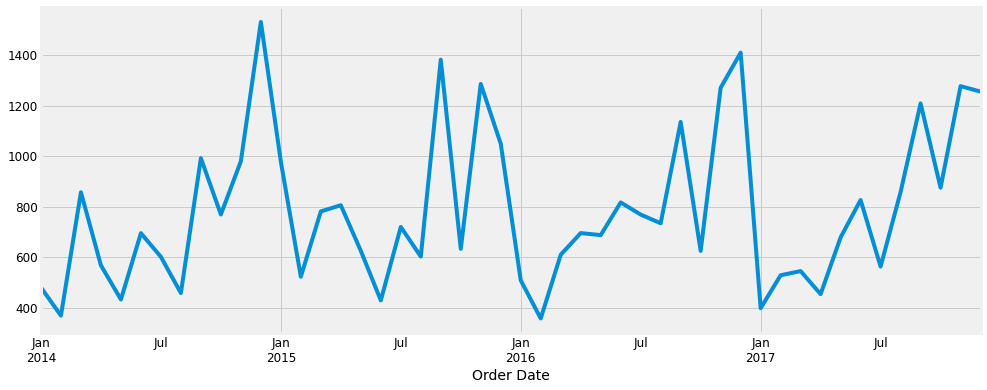

In [0]:
y.plot(figsize=(15, 6))
plt.show()

Some distinguishable patterns appear when we plot the data. The time-series has seasonality pattern, such as sales are always low at the beginning of the year and high at the end of the year. There is always an upward trend within any single year with a couple of low months in the mid of the year.

We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

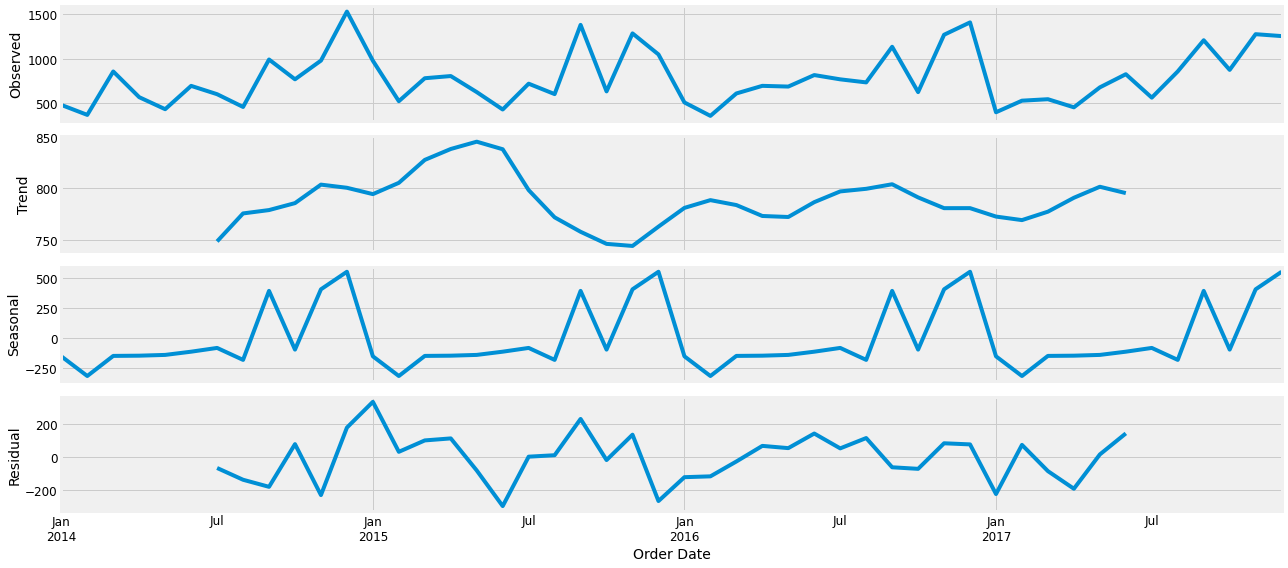

In [14]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

##Time series forecasting with ARIMA

We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.

ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data:

In [17]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


This step is parameter Selection for our furniture’s sales ARIMA Time Series Model. Our goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model.

In [21]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:769.0817523205916
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1526.6646435881128
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:477.71701309202774
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:497.2314433418337


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1402.3936867800505
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:318.0047199116341
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:720.92522707581
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2900.5279890044303
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:466.5607429809134


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:499.5730681144165
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:nan
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:319.98848769468657
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:677.894766843944
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1420.8968510776567
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:486.6378567198382
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:497.78896630044073


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1283.8048690707233
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:319.7714068109211
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:649.9056176817081
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:2568.9604692368553
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:458.8705548482836
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:486.1832977442527
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:2982.3212858304873
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:310.7574368417338
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:692.1645522067712
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1378.8837536991703
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:479.46321478521355


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:480.9259367935194
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:1355.0241301172382
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:304.4664675084582
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:665.779444218597
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:3132.313062242019
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:468.36851958151317
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:482.5763323876961
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:2763.15984565311
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:306.01560021460404
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:671.2513547541902
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1412.2716724812103
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:479.20034222811347
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:475.3403658784957


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:1284.3702695020268
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:300.6270901345411
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:649.0318019835028
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:2726.367540279938
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:460.47626876100463
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:469.5250354660781
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:2625.787905160848
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:297.7875439531316


The above output suggests that SARIMAX(1, 1, 1)x(1, 1, 0, 12) yields the lowest AIC value of 297.78. Therefore we should consider this to be optimal option.

##Fitting the ARIMA model

In [24]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0146      0.342      0.043      0.966      -0.655       0.684
ma.L1         -1.0000      0.360     -2.781      0.005      -1.705      -0.295
ar.S.L12      -0.0253      0.042     -0.609      0.543      -0.107       0.056
sigma2      2.958e+04   1.22e-05   2.43e+09      0.000    2.96e+04    2.96e+04


We should always run model diagnostics to investigate any unusual behavior.

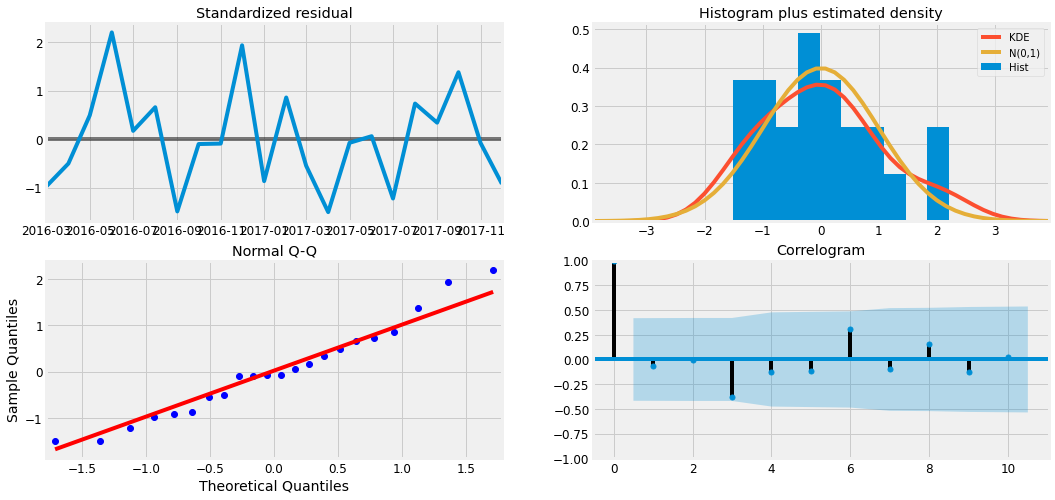

In [25]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

It is not perfect, however, our model diagnostics suggests that the model residuals are near normally distributed.

##Validating forecasts

To help us understand the accuracy of our forecasts, we compare predicted sales to real sales of the time series, and we set forecasts to start at 2017–01–01 to the end of the data.

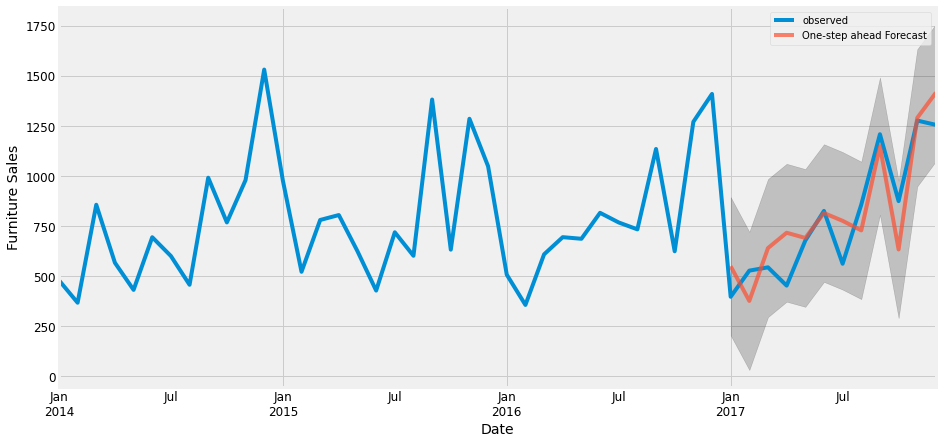

In [30]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()